In [96]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler


import networkx as nx
from matplotlib import cm
import graphviz
import math

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Hakaton/statistics-07-20.csv', sep = ';')

# Анализ данных

In [72]:
data.head()

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,...,operation_st_id,operation_train,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto
0,NaN,NaN,62827035,984700.0,NaN,NaN,NaN,2.0,81.0,2020-07-16 03:40:00,...,2.000039e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,62827035,862201.0,20.0,NaN,421034.0,NaN,18.0,2020-07-16 14:10:00,...,2.002026e+09,NaN,93149858.0,60.0,NaN,68398528.0,NaN,NaN,249.0,NaN
2,NaN,NaN,62827316,863007.0,NaN,NaN,NaN,2.0,80.0,2020-07-16 14:50:00,...,2.001933e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,62827381,862108.0,NaN,NaN,NaN,2.0,80.0,2020-07-16 14:16:00,...,2.001931e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,62845730,887904.0,20.0,NaN,421034.0,NaN,19.0,2020-07-16 15:15:00,...,2.000039e+09,NaN,81195103.0,60.0,NaN,52682351.0,NaN,NaN,248.0,NaN


In [73]:
# # функция для поиска пустых данных
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])

In [74]:
# # функция для поиска дубликатов по столбцам
def find_duplicates_by_columns(df):  
    duplicates = []
    column = []
    for i in df.columns:
        duplicates.append(df[i].duplicated().sum())
        column.append(i)
    duplicates = pd.Series(duplicates) 
    column = pd.Series(column) 
    return pd.concat([column, duplicates], axis = 1,
                     keys = ['column', 'duplicates']).sort_values(by = 'duplicates',ascending = False).head(40)

In [75]:
#Поиск пустых данных
missing_data(data)

,Total,Percent
danger,4077929,97.327249
tare_weight,3085197,73.633880
adm,3085197,73.633880
rod_train,2623663,62.618526
weight_brutto,2623318,62.610292
ssp_station_id,2255185,53.824123
operation_train,2222194,53.036732
ssp_station_esr,2222193,53.036708
index_train,2222193,53.036708
gruz,1779461,42.470098


In [76]:
#Поиск дубликатов
find_duplicates_by_columns(data)

,column,duplicates
5,danger,4189913
7,loaded,4189911
14,rodvag,4189903
4,adm,4189901
12,operation_train,4189901
8,operation_car,4189894
15,rod_train,4189887
1,length,4189838
19,tare_weight,4189580
11,operation_st_id,4189170


In [77]:
cm=data.operation_car[data.operation_car.notnull()].nunique()


In [18]:
#справочник по операциям с вагонами
#car_ops = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Hakaton/VIVSD_ASOUP_NSI_TN_OPER_VAG.csv',sep=',', encoding='utf-8')
#car_ops.head()
#print('Уникальных операций с вагонами в датасете:')
#for i in data.operation_car[data.operation_car.notnull()].value_counts().index:
#    print(i,car_ops.naimen_oper[car_ops.index_code == i].values)

,dor_nsi,id,kop,mnem_oper,naimen_oper,naimen_oper_s,ont_time_write,request_unq_seq,req_date_time
0,0,1.900750e+12,0,КОН,ОКОНЧАНИЕ ПЕРЕВОЗКИ ГРУЗА НА СВ.ОСЯХ,ОК.ПЕРЕВОЗ ГР.НА СВ.ОСЯХ,02.10.2020 2:24,1.900750e+12,02.10.2020 2:24
1,0,1.900750e+12,2,ОТПР,ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ,ОТПР СО СТАНЦИИ,02.10.2020 2:24,1.900750e+12,02.10.2020 2:24
2,0,1.900750e+12,3,ИСКП,ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА,ИСКЛ ИЗ ПОЕЗДА,02.10.2020 2:24,1.900750e+12,02.10.2020 2:24
3,0,1.900750e+12,4,ВКЛП,ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД,ВКЛ. В ПОЕЗД,02.10.2020 2:24,1.900750e+12,02.10.2020 2:24
4,0,1.900750e+12,5,ПРМД,ПРИЕМ ПО МЕЖДОРОЖНОМУ СТЫКУ,ПРМ ПО МЕЖДОР. СТЫКУ,02.10.2020 2:24,1.900750e+12,02.10.2020 2:24


# Предобработка

In [78]:
data.operation_date = pd.to_datetime(data.operation_date, format='%Y-%m-%d %H:%M')
data.operation_date

0         2020-07-16 03:40:00
1         2020-07-16 14:10:00
2         2020-07-16 14:50:00
3         2020-07-16 14:16:00
4         2020-07-16 15:15:00
                  ...        
4189910   2020-07-16 03:29:00
4189911   2020-07-16 03:30:00
4189912   2020-07-15 20:00:00
4189913   2020-07-16 02:37:00
4189914   2020-07-16 04:28:00
Name: operation_date, Length: 4189915, dtype: datetime64[ns]

In [79]:
#заполнениe нулевых значений в наборе данных
#Признак опасного груза в вагоне

data.danger = data.danger.fillna(0)

In [80]:
#узнаем размерность
data.shape

(4189915, 21)

In [81]:
data.danger = data.danger.fillna(0)
data = data.sort_values(by = ['operation_date'], ascending = True)
#пересортируем строки (drop=True - для удаления старых индексов)
data = data.reset_index(drop = True)

# Получение всех подходящих условию операций включения вагонов в поезд для всех вагонов на всех станциях

In [82]:
# возвращает список датафреймов со всеми операцифми по каждому уникальному вагону 
def get_data_vags(data):
    
    data_vags_stack = [] 
    vags_numbers = data['car_number'].unique()
    print('Собираются датафреймы для каждого из {} уникальных вагонов :'.format(len(vags_numbers)))
    for vags_number in tqdm(vags_numbers):
        vag_df = pd.DataFrame(data[data.car_number == vags_number].sort_values(by = ['operation_date'], ascending = True))
        vag_df = vag_df.reset_index(drop=True)
        data_vags_stack.append(vag_df)
        
    return data_vags_stack #список датафрейфмов

In [83]:
# принимает датафрейм со всеми операцифми по каждому уникальному вагону
# возвращат список датафреймов, где каждый элемент - датафрейм одного уникального вагона на одной уникальной станции
def split_data_vag_into_stations(data_vag):  
    
    data_vags_st_stack = []
    st_esrS = data_vag.operation_st_esr.unique()
    for st_esr in st_esrS:
        vag_st_df = pd.DataFrame(data_vag[data_vag.operation_st_esr == st_esr].sort_values(by = ['operation_date'], ascending = True))
        vag_st_df = vag_st_df.reset_index(drop = True)
        data_vags_st_stack.append(vag_st_df)
    
    return data_vags_st_stack # стек датафреймов одного вагона на разных станциях

Для каждого датафрейма с данными об уникальном вагоне на уникальной станции за все время, ищутся operation_train in ([ 2., 62., 22., 42.] ), идем по наблюдениям назад по времени и ищем первую встречную operation_car == 4, идем по наблюдениям назад по времени до предыдущего отправления в operation_train и если в интервале есть операции погрузки/выгрузки до текущей операции включения, значит данную операцию включения в поезд берем, если же в интервале нет операций погрузки выгрузки, то переходим к предыдущей операции включения и проверяем её интервал до отправления на наличие операций погрузки/выгрузки. Из нескольких подходящих вышеуказанному условию наблюдений внутри каждого интервала (между отправлениями поезда), в которых операция с вагоном == операция включения в поезд, берем только одну последнюю операцию включения в поезд.


In [84]:
# принимает датафрейм с данными об уникальном вагоне на уникальной станции за все время
# возвращает датафрейм с операциями включения, подходящими условию, для одного уникального вагона на одной уникальной станции
# operation_car Код операции ВМ  АСОУП
# operation_train Код операции ПМ  АСОУП
def get_includes(data_vag_st):
    
    buffer = []
    for i in reversed(range(len(data_vag_st))): # идем по последнним наблюдениям к боллее старым для каждого датафрейма с данными об уникальном вагоне на уникальной станции за все время
        if (data_vag_st.loc[i, 'operation_train'] in (2, 62, 22, 42)) & (i>0): # находим операцию отправления поезда
        # условие operation_car пусто, operation_train не пусто
        #https://rts-nn.ru/info/
        ##https://cargolk.rzd.ru/catalogs/cargo_operations
        #https://online.freicon.ru/info/wagon-operations?page=3&perPage=25
            j = i-1
            valid_inclusion_operations_indexes = [] #подходящие вагоны с операцией включения
            while (data_vag_st.loc[j, 'operation_train'] not in (2, 62, 22, 42)) & (j>0):# ограничиваем поиск операции включения предыдущей операцией отправления поезда
                if data_vag_st.loc[j, 'operation_car'] == 4:  #находим операции включения в поезд перед последней операцией отправления
                    flag = False
                    k = j-1
                    while (data_vag_st.loc[k, 'operation_train'] not in (2, 62, 22, 42)) & (k>=0): #ограничиваем интервал до предыдущей операции отправления поезда
                        if data_vag_st.loc[k, 'operation_car'] in (10,11,13,14,15,17,18,19,20,21,23,24,25,28,29):#проверяем наличие хоть одной операции разгрузки/погрузки
                        # цифры взяты из предложенного селекта ((kop_vmd >= 10 and kop_vmd <= 19) or (kop_vmd >= 20 and kop_vmd <= 29)) and date_op<=DATE('2021-08-31') and date_op>=DATE('2021-08-01')
                            flag = True 
                        if k > 0:
                            k -= 1                # смотрим предыдущие записиси в интервале
                        else:
                            break  
                    if flag == True:
                        valid_inclusion_operations_indexes.append(j)
                j-=1
                
            if valid_inclusion_operations_indexes : buffer.append(data_vag_st.iloc[valid_inclusion_operations_indexes[0]]) # список может быть пустым, поэтому есть данное условие
            
    return pd.DataFrame(data = buffer).reset_index(drop = True)

In [85]:
# возвращает стек непустых датафреймов с операциями включения,соответствующих условию, для каждого вагона на всех станциях
def get_all_includes_by_vags(data):
    data_vags_stack = get_data_vags(data)
    includes_by_vags = []
    print('Идет поиск необходимых операций включений для каждого уникального вагона из {} :'.format(len(data_vags_stack)))
    for data_vag in tqdm(data_vags_stack):
        data_vag_stations_stack = split_data_vag_into_stations(data_vag)
        includes_by_vag_st = [] # те, что получились здесь с разных станций сложим в один датафрейм ( для каждого вагона)
        for data_vag_station in data_vag_stations_stack:
            includes_by_vag_st.append(get_includes(data_vag_station))
            
        includes_by_vag_df = pd.concat([x for x in includes_by_vag_st]) # соединим датафреймы с каждой отдельной станцей в один для каждого вагона
        includes_by_vags.append(includes_by_vag_df)
    return [df for df in includes_by_vags if not df.empty]

In [86]:
# соединяет датафреймы друг с другом
def get_includes_df(all_includes_by_vags):
    df_includes = pd.concat([x for x in all_includes_by_vags])
    print('Общее по всем вагонам количество подходящих условию операций включения составило {}'.format(df_includes.shape[0]))
    return df_includes

In [87]:
%%time
all_includes_by_vags = get_all_includes_by_vags(data)

Собираются датафреймы для каждого из 441248 уникальных вагонов :


  0%|          | 0/441248 [00:00<?, ?it/s]

Идет поиск необходимых операций включений для каждого уникального вагона из 441248 :


  0%|          | 0/441248 [00:00<?, ?it/s]

CPU times: user 2h 10min 17s, sys: 5min 15s, total: 2h 15min 33s
Wall time: 1h 49min 33s


In [88]:
df_includes = get_includes_df(all_includes_by_vags)

Общее по всем вагонам количество подходящих условию операций включения составило 501850


In [23]:
df_includes.to_csv('/content/drive/MyDrive/ColabNotebooks/Hakaton/clear_data.csv')

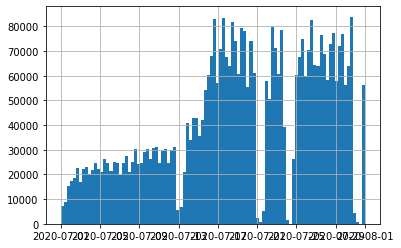

In [26]:
#
# Ниже видно, что в исходных данных есть провал.  
#  Возможно данные так были выгружены, или по какой-то причине отсутствуют в системе.
#
#Было
data.operation_date.hist(bins=100,)

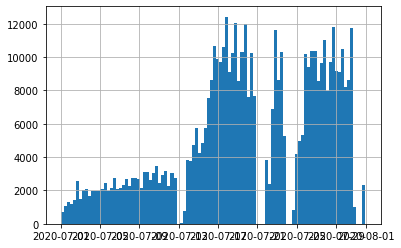

In [21]:
# Стало
df_includes.operation_date.hist(bins=100,)

**Справочный блок**

In [89]:
print(f'Размерность датасета: {df_includes.shape}\n')
print(f'Временной диапазон:\nmin: {df_includes.operation_date.min()}\nmax: {df_includes.operation_date.max()}\n')

print(f'Уникальных станций: {df_includes.operation_st_id.nunique()}')
print(f'Уникальных вагонов: {df_includes.car_number.nunique()}\n')

print(f'Уникальных операций с вагонами: {df_includes.operation_car[df_includes.operation_car.notnull()].nunique()}')
print(f"Уникальных операций с поездами: {df_includes.operation_train[df_includes.operation_train.notnull()].nunique()}")

Размерность датасета: (501850, 21)

Временной диапазон:
min: 2020-07-01 00:40:00
max: 2020-07-31 23:00:00

Уникальных станций: 666
Уникальных вагонов: 299181

Уникальных операций с вагонами: 1
Уникальных операций с поездами: 4


In [90]:
vag_dict_df=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Hakaton/VIVSD_ASOUP_NSI_TN_OPER_VAG.csv')
poezd_dict_df=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Hakaton/VIVSD_ASOUP_NSI_TN_OPER_POEZD.csv')

In [91]:
print('Уникальных операций с вагонами в датасете:')
for i in df_includes.operation_car[df_includes.operation_car.notnull()].value_counts().index:
    print(i,vag_dict_df.naimen_oper[vag_dict_df.dor_nsi == i].values)

Уникальных операций с вагонами в датасете:
4.0 []


In [92]:
print('Уникальных операций с поездами в датасете:')
for i in df_includes.operation_train[df_includes.operation_train.notnull()].value_counts().index:
    print(i,poezd_dict_df.mnem_oper[poezd_dict_df.dor_nsi == i].values)

Уникальных операций с поездами в датасете:
5.0 []
71.0 []
30.0 []
35.0 []


In [93]:
#Переменные st_id и car_num
## В этой ячейке задаются переменные st_id - ЕСР станции, car_num - номер вагона.
## Задавая значения переменным можно проводить визуальный анализ по определенной станции или вагону.

"""
Примеры номеров станций ['operation_st_esr']
"""
# st_id = 889505 # 100 ops, 4 cars
# st_id = 845009 # 90 ops, 28 cars
# st_id = 977000 # 50 ops, 10 cars
# st_id = 985906 # 207037 ops, 43702 cars
# st_id = 925701 # 37386 ops, 3801 cars
# st_id = 926206 # 18489 ops, 363 cars
# st_id = 880407
# st_id = 967704 # станция с аномальными данными - таможенный пост Морской порт Ванино 
# st_id = 881804
# st_id = 986103 # top-1 by dest # НАХОДКА-ВОСТОЧНАЯ (ЭКСП.) https://www.logistics1520.com/railway/station/98610-nahodka-vostochnaya-eksp/
# st_id = 863007 # 5th by destination
# st_id = 950101
# st_id = 954704
st_id = 968707 # Дземги - https://www.logistics1520.com/railway/station/96870-dzemgi/


"""
Примеры номеров вагонов ['car_number']
"""
# car_num = 55864821 # вагон с максимальным количеством операций 310
# car_num = 94033792
# car_num = 62324355
# car_num = 37843901
# car_num = 61810677
# car_num = 37812401
# car_num = 37695855
# car_num = 30849038
# car_num = 63852057
# car_num = 42051045
# car_num = 44591014
# car_num = 55864821
# car_num = 62236872
# car_num = 30860712
# car_num = 30870752
# car_num = 42051359
# car_num = 42780155
# car_num = 30061394
# car_num = 55952550
car_num = 67062638 ## вагон с наглядым графом перехода состояний
# car_num = 53447488
#car_num = 54643101

"""
Примеры номеров поездов ['index_train']
"""
train_num = 932300948920002#954704366955406

#######################

# проверка соответствия st_id и car_num
def check_st_car(st_id, car_num):
    if df_includes.operation_st_esr[df_includes.car_number == car_num][df_includes.operation_st_esr == st_id].shape[0] == 0:
        print(f'Для станции {st_id} нет записей с вагоном {car_num}')
        print(f'\nТоп 10 вагонов по количеству записей для станции:\n')
        print(
            pd.DataFrame(
                {'Вагон': df_includes.car_number[df_includes.operation_st_esr == st_id].value_counts().index[:10],
                 'Строк': df_includes.car_number[df_includes.operation_st_esr == st_id].value_counts().values[:10]}
            )

        )
        print(f'\nС вагоном {car_num} есть записи на следующих станциях:\n')
        print(
            pd.DataFrame(
                {'Станция': df_includes.operation_st_esr[df_includes.car_number == car_num].value_counts().index,
                 'Строк': df_includes.operation_st_esr[df_includes.car_number == car_num].value_counts().values}
            )
        )

    else:
        print(
            f'Для станции {st_id} есть \
{df_includes.operation_st_esr[df_includes.car_number == car_num][df_includes.operation_st_esr == st_id].shape[0]} \
строк(а) по вагону {car_num}'
        )


check_st_car(st_id, car_num)
print(f'\nВагон {car_num} также присутствует в записях со следующими поездами: \n\n\
{df_includes.index_train[df_includes.car_number == car_num].value_counts()}')

Для станции 968707 нет записей с вагоном 67062638

Топ 10 вагонов по количеству записей для станции:

      Вагон  Строк
0  51269041      3
1  73039448      3
2  50816792      3
3  57109548      3
4  54724364      3
5  73347288      3
6  54883442      3
7  57525149      2
8  54884044      2
9  51815918      2

С вагоном 67062638 есть записи на следующих станциях:

Empty DataFrame
Columns: [Станция, Строк]
Index: []

Вагон 67062638 также присутствует в записях со следующими поездами: 

Series([], Name: index_train, dtype: int64)


In [94]:
def extract_car(car_number):
    lst = []
    for i,j in enumerate(str(car_number)):
        if i == 0 and j == '2':
            lst.append('крытый')
        elif i == 0 and j == '3':
            lst.append('специальный вагон (к примеру, четырехосный думпкар, хоппер-дозатор, транспортер)')
        elif i == 0 and j == '4':
            lst.append('платформы')
        elif i == 0 and j == '5':
            lst.append('означает, что вагон отнесен к группе собственных грузовых вагонов и не входит в состав парка ОАО «РЖД»')
        elif i == 0 and j == '6':
            lst.append('полувагон')
        elif i == 0 and j == '7':
            lst.append('цистерны')
        elif i == 0 and j == '8':
            lst.append('изотермические')
        elif i == 0 and j == '9':
            lst.append('прочие')
        elif i == 1 and j == '2':
            lst.append('двух осный')
        elif i == 1 and j == '4':
            lst.append('четырех осный')
        elif i == 1 and j == '6':
            lst.append('шести осный')
        elif i == 1 and j == '8':
            lst.append('восьми осный')
        elif i == 1 and j == '12':
            lst.append('двенадцати осный')
        elif i == 1 and j == '16':
            lst.append('шестнадцати осный')
        elif i == 2 and j == '5':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '6':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '7':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '8':
            lst.append('цистерна с объемом котла 75 м3')
        elif i == 2 and j == '9':
            lst.append('цистерна с объемом котла 85,6 м3')
        elif i == 3 and j.isdigit():
            lst.append('номер вагона который был присвоен заводом: {}'.format(j))
        elif i == 4 and j.isdigit():
            lst.append(j)
        elif i == 5 and j.isdigit():
            lst.append(j)
        elif i == 6 and j.isdigit():
            lst.append('имеется ручной тормоз или переходная площадка, код: {}'.format(j))
        elif i == 7 and j.isdigit():
            lst.append('контрольное число вагона: {}'.format(j))
        else:
            continue
            
    print(f'Вагон {car_num} был отмечен на следующих станциях:\n')
    for i in df_includes.operation_st_esr[df_includes.car_number == car_num].unique(): print(i)

    print(f'\nВагон {car_num} был отмечен в следующих поездах:\n')
    for i in df_includes.index_train[df_includes.car_number == car_num].unique(): 
        if np.isnan(i): 
            continue
        else:
            print(int(i))
    print(f'\nСвойства:\n{lst}')

In [95]:
#Визуализация датасета
print(f'Для визуализации используются следующие переменные:\n\nst_id \t= {st_id}\ncar_num = {car_num}\n')
print(f'В датасете по станции {st_id} имеются записи по:\n\n{df_includes.car_number[df_includes.operation_st_esr == st_id].nunique()} вагонам и\n{df_includes[df_includes.operation_st_esr == st_id].shape[0]} операциям\n')
extract_car(car_num)

Для визуализации используются следующие переменные:

st_id 	= 968707
car_num = 67062638

В датасете по станции 968707 имеются записи по:

2428 вагонам и
2899 операциям

Вагон 67062638 был отмечен на следующих станциях:


Вагон 67062638 был отмечен в следующих поездах:


Свойства:
['полувагон', 'номер вагона который был присвоен заводом: 6', '2', '6', 'имеется ручной тормоз или переходная площадка, код: 3', 'контрольное число вагона: 8']


**Графики**

In [98]:
class Graph:

    def __init__(self):

        self.prev = 0
        self.edges = []
        self.weighted_edges = []
        self.weights = []
        self.edge_labels = dict()
        self.networkx_graph = nx.DiGraph()

    def add_edge(self, edge):
        self.edges.append(edge)

    def set_edge(self, edge):
        self.edges = edge

    def write_graph(self, val):
        self.add_edge([self.prev, val])
        self.prev = val

    def count_weights(self):
        values_weights = pd.Series(self.edges).value_counts()
        df = values_weights.to_frame(name="Weight")
        self.edges = df.index
        df["Edges"] = df.index
        df["A"], df["B"] = df.Edges.str
        self.weighted_edges = df.to_numpy()[:, [2, 3, 0]]
        self.weights = list(values_weights)

    def make_colors(self):
        colors = [i / len(self.networkx_graph.nodes) for i in range(len(self.networkx_graph.nodes))]
        self.bright_cmap = cm.jet(colors)
        cmap = cm.jet(colors)
        for i in cmap:
            i[3] = i[3] * 0.5
        self.cmap = cmap
        
    def get_edge_labels(self):
        for row in self.weighted_edges:
            self.edge_labels[tuple(row[[0, 1]])] = row[2]
        
    def prepare_prop(self):
        
        self.count_weights()
        
        #prepare networkxGraph
        self.networkx_graph.add_edges_from(self.edges)
        
        self.make_colors()
        self.get_edge_labels()

    def draw_graph(self, figsize=(50, 50), show_weights=True, \
                  width=2, show_weights_labels=True, \
                  node_size=1000, font_size=15, \
                  font_family="fantasy", weightsmark_font_color='red',\
                  weightsmark_font_size = 10, width_count_method = 'log'):
        
        self.prepare_prop()
        #self.cmap='viridis'
        
        if (show_weights):
            width = list(map(lambda x: math.log(x) if width_count_method == 'log' else x, self.weights))
        else:
            width = width
        
        
        plt.figure(figsize=figsize)
        
        layout = nx.spring_layout(self.networkx_graph)
        
        nx.draw_networkx(self.networkx_graph, layout, with_labels=True, \
                         node_color=self.cmap, node_size=node_size, \
                         font_size=font_size, \
                         font_family=font_family, width=width)
        
        if (show_weights_labels):
            nx.draw_networkx_edge_labels(self.networkx_graph, pos=layout, \
                                         edge_labels=self.edge_labels, \
                                         font_color=weightsmark_font_color, \
                                         font_size = weightsmark_font_size)
        
        #plt.tight_layout()
        #plt.show()
        plt.savefig("Graph.png", format="PNG")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


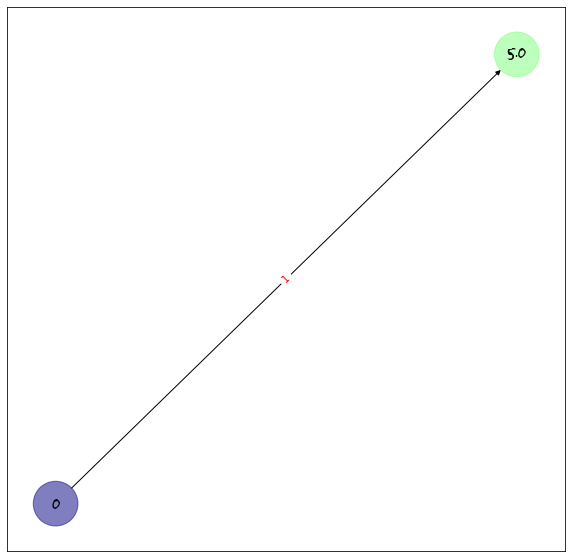

In [99]:
#Построить рандомный вагон
#!pip install networkx
#import networkx as nx
#from matplotlib import cm
#import matplotlib.pyplot as plt
#import graphviz
#import math

random_graph_object = Graph()
svag_df['operation_train'].apply(lambda x: random_graph_object.write_graph(x))
random_graph_object.draw_graph(figsize=(10, 10), width_count_method=None, node_size=2000)

In [100]:
def get_sample_df(data, col):
    return data[data[col] == data[col].sample().values[0]]

In [101]:
stan_df=get_sample_df(df_includes, 'destination_esr')
stan_df['operation_train']=stan_df['operation_train'].apply(vag_dict.to_dict()['mnem_oper'].get)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1055 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1056 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1052 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1044 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1055 missing from current font.
  font.set_text(s, 0, flags=flags

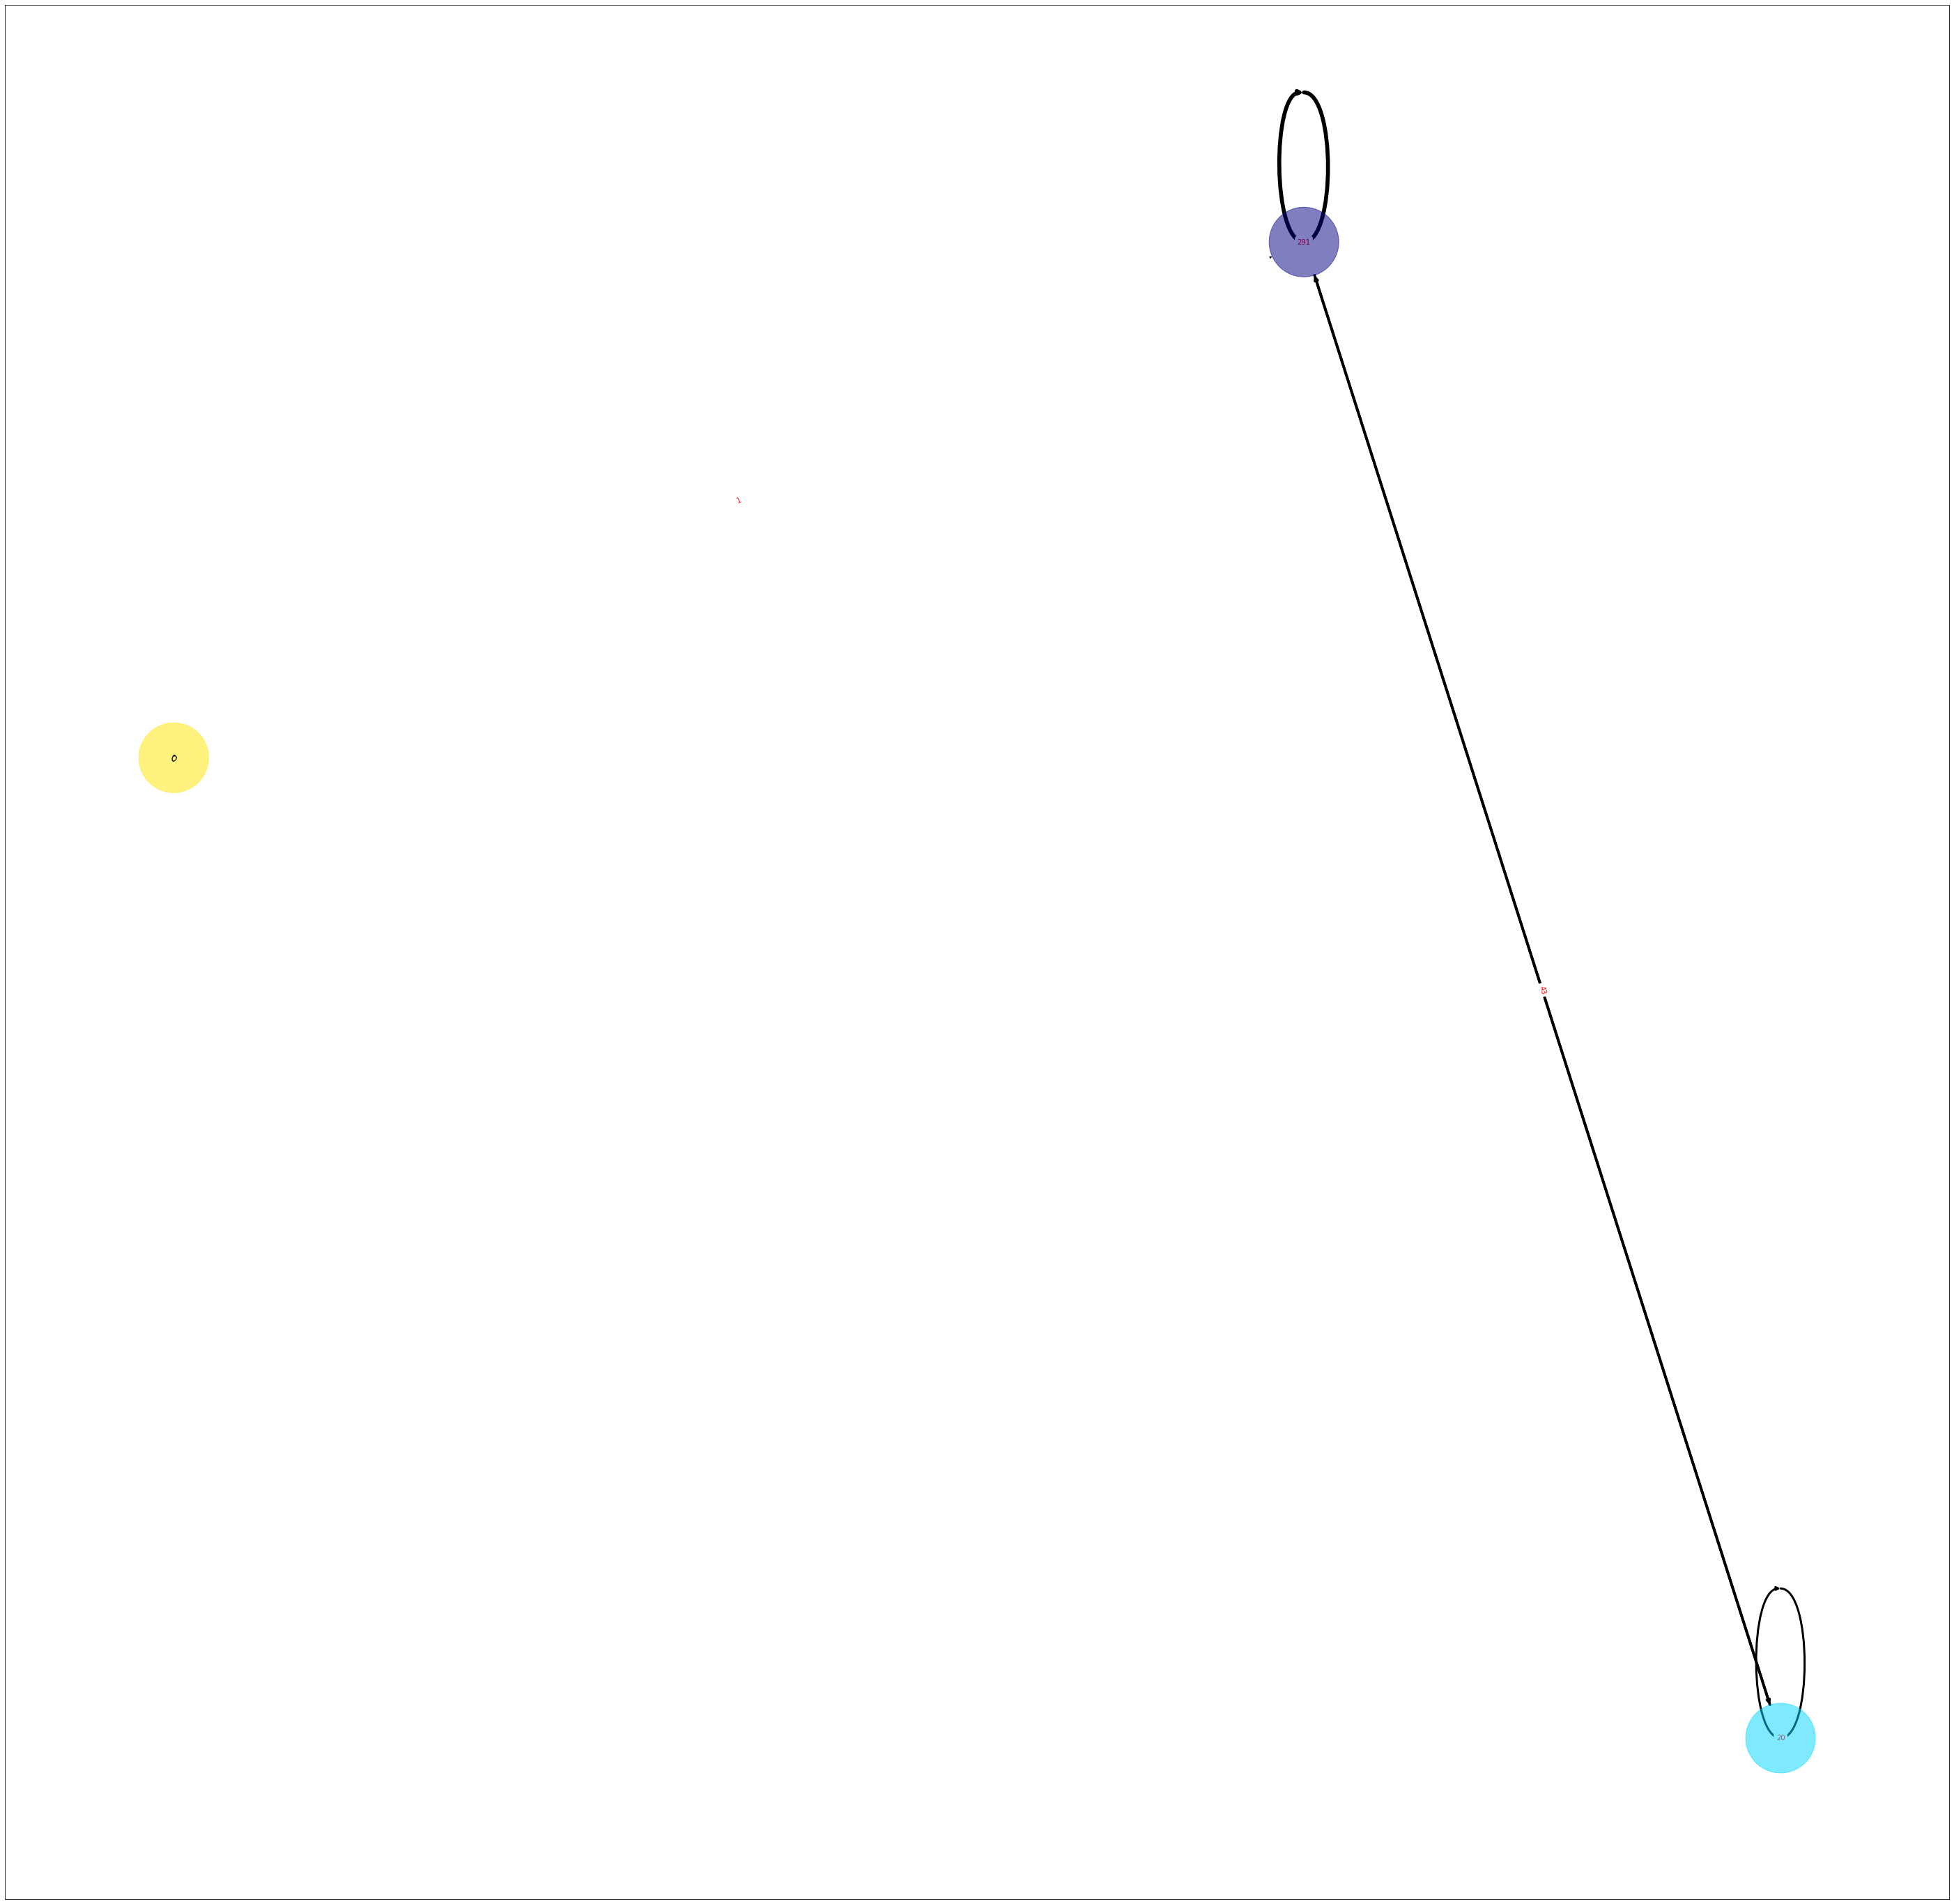

In [103]:
graph_object = Graph()
stan_df['operation_train'].apply(lambda x: graph_object.write_graph(x))
graph_object.draw_graph(figsize=(50, 50), node_size=10000)

In [104]:
  graph_object.networkx_graph

In [105]:
d=stan_df['operation_train'].apply(vag_dict.to_dict()['mnem_oper'].get)

In [106]:
d

0    None
0    None
0    None
0    None
0    None
     ... 
0    None
0    None
0    None
0    None
0    None
Name: operation_train, Length: 398, dtype: object